In [1]:
import pandas as pd
import subprocess
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
#export_folder = "~/sysmex2pf/interval_processing"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

# Phenotypes GWAS

## Read files

In [116]:
agonists = ["ADP","CRP","PAR4","TRAP"]
bolt_gwas = {}

In [117]:
def add_abs_pos(df):
    offset = 0
    df["ABS_POS"] = df["BP"]
    for ch in range(1,23):
        c = df.CHR == ch
        df.loc[c,"ABS_POS"] = df.loc[c,"BP"] + offset
        offset += df.loc[c,"BP"].max()

In [118]:
for ago in agonists:
    df = pd.read_csv("%s/bolt_res_%s_FIB" % (export_folder,ago), sep="\t")
    df = df.dropna(axis=0,how="any")
    add_abs_pos(df)
    df["exp"] = ago
    df["MBP"] = (df["BP"]/1e6).astype(int)
    bolt_gwas[ago] = df

In [119]:
bolt = pd.concat([bolt_gwas[ago] for ago in agonists],axis=0)

In [120]:
bolt.sample(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM,ABS_POS,exp,MBP
2638913,rs17031131,4,155008496,0,T,G,0.760195,0.038138,0.007862,0.007373,0.29,0.28,845397276,ADP,155
8723585,rs6050282,20,25035310,0,A,C,0.139498,0.025256,0.004739,0.009024,0.60,0.63,2742788891,ADP,25
1868793,rs55957335,3,124708350,0,CA,C,0.374601,0.023120,-0.011468,0.007050,0.10,0.10,617134749,CRP,124


## Best-of tables

In [121]:
def add_block_to_df(df, validated_snps):
    # Groups SNPs in blocks
    # df must be in the bolt_lmm format
    df["block"] = -1
    
    #validated_snps = [s[:-1] for s in open("%s/validated_snps/ADP.txt" % export_folder,"r").readlines()]
    
    p_cond = (df.SNP.isin(validated_snps)) & (df.SNP != ".")
    agg = AgglomerativeClustering(distance_threshold=int(1e6),linkage="single",n_clusters=None)
    global_offset = 0
    for ch in df.loc[p_cond].CHR.unique().tolist():
        s_cond = p_cond & (df.CHR == ch)
        if (s_cond.sum() > 1):
            labels = agg.fit_predict(np.reshape(df.loc[s_cond,"BP"].values,(-1,1)))
        else:
            labels = np.array([1])
        df.loc[s_cond,"block"] = labels + global_offset
        global_offset += np.max(labels) + 1
    return df

In [108]:
def best_of(df, threshold = 5e-8):
    df = add_block_to_df(df.copy(),df.loc[df.P_BOLT_LMM < threshold].SNP.tolist())
    return df.loc[df.block  > -1].groupby(["CHR", "block"])[["MBP","SNP","P_BOLT_LMM","A1FREQ","BETA"]].first().reset_index()

In [9]:
best_of(bolt.loc[bolt.exp == "ADP"])

MBP          SNP    P_BOLT_LMM    A1FREQ
CHR block                                          
1   0      171   rs73031718  1.400000e-09  0.875026
    1      198   rs12132016  3.100000e-09  0.763101
    2      113    rs7512948  4.600000e-08  0.469162
    3        1   rs12068889  2.600000e-08  0.983450
    4      156   rs72698679  1.200000e-08  0.897258
    5      207    rs4142866  1.900000e-08  0.490062
2   6       31     rs711229  1.500000e-08  0.312709
4   7        6   rs11734099  9.900000e-09  0.825542
5   8      122    rs4240383  1.900000e-08  0.177935
    9      150    rs4958450  4.200000e-08  0.629639
6   10     137    rs9494600  4.200000e-08  0.359396
    11      25   rs10498727  2.500000e-08  0.863528
    12     158     rs688181  3.100000e-10  0.281006
7   13      80   rs10282644  1.600000e-08  0.546175
    14     106    rs1496142  5.500000e-15  0.520970
8   15     144    rs3923387  1.300000e-08  0.583620
    16     106    rs4734869  2.300000e-18  0.746265
9   17     113  rs137950543  1.800000e-08  0.981691
10  18      64   rs10995445  4.000000e-10  0.526341
11  20       0   rs55966801  4.400000e-08  0.784163
12  21      54   rs10506328  2.700000e-08  0.361099
15  22      65    rs4777602  1.500000e-11  0.862002
16  23      28     rs151234  3.300000e-13  0.871505
    24      81    rs6564923  6.900000e-09  0.831497
17  25       4    rs8068188  7.300000e-09  0.150552
18  26       9     rs329004  3.700000e-08  0.845815
19  27      55  rs530895836  1.100000e-10  0.216427
    28      16    rs8109288  5.400000e-09  0.981742
    29      38   rs35496032  8.100000e-12  0.986586
20  30       1   rs73076965  1.800000e-08  0.802577
    31      57   rs34524896  2.400000e-09  0.951588
22  32      43    rs9607948  4.100000e-08  0.543527

In [10]:
best_of(bolt.loc[bolt.exp == "CRP"])

MBP          SNP    P_BOLT_LMM    A1FREQ
CHR block                                          
1   0      171   rs73031718  6.200000e-13  0.875026
    1      113    rs4838959  4.200000e-09  0.461582
    2      198   rs12132016  3.700000e-08  0.763101
    3      156   rs72698679  1.800000e-08  0.897258
    4      207    rs4142866  1.500000e-08  0.490062
2   5       31  rs144609065  1.200000e-09  0.289850
4   6        6   rs11734099  9.400000e-09  0.825542
5   7      122    rs4240383  6.100000e-09  0.177935
    8      150    rs4958267  2.000000e-08  0.634806
6   9      137    rs9494600  2.100000e-08  0.359396
    10      25   rs10498727  5.800000e-09  0.863528
    11     110    rs9374170  2.500000e-08  0.564147
    12     158     rs624497  3.600000e-09  0.288301
7   13      80    rs9649527  3.500000e-08  0.546266
    14     106    rs1496142  8.900000e-16  0.520970
    15     116   rs13239000  4.400000e-08  0.751989
8   16     144    rs7010805  4.200000e-08  0.531841
    17     106    rs4734869  1.100000e-17  0.746265
9   19     113  rs117149770  2.800000e-08  0.973409
10  20      64   rs10761716  1.500000e-09  0.557885
12  21      54   rs10506328  1.500000e-08  0.361099
15  22      65    rs4777602  1.700000e-10  0.862002
16  23      28     rs151234  3.400000e-14  0.871505
    24      81   rs62044137  4.300000e-09  0.866608
17  25       4   rs12602901  1.600000e-08  0.816683
18  26       9  rs148192036  3.600000e-08  0.846922
19  27      55  rs530895836  3.000000e-08  0.216427
    28      16    rs8109288  1.500000e-09  0.981742
    29      38   rs35496032  2.200000e-09  0.986586
20  30       1   rs73076965  3.100000e-09  0.802577
    31      57  rs193284505  4.200000e-08  0.990202
22  32      43  rs149290032  3.200000e-10  0.548378

## Merge ADP-CRP

In [74]:
adp_crp = pd.merge(best_of(bolt.loc[bolt.exp == "ADP"]).reset_index(), 
         best_of(bolt.loc[bolt.exp == "CRP"]).reset_index()[["SNP","P_BOLT_LMM","CHR","MBP"]],
         left_on="SNP",right_on="SNP",how="outer",suffixes=("_ADP","_CRP"))

In [75]:
adp_crp["CHR"] = adp_crp["CHR_ADP"]
adp_crp.loc[adp_crp.CHR.isnull(),"CHR"] = adp_crp.loc[adp_crp.CHR.isnull(),"CHR_CRP"]
adp_crp["MBP"] = adp_crp["MBP_ADP"]
adp_crp.loc[adp_crp.MBP.isnull(),"MBP"] = adp_crp.loc[adp_crp.MBP.isnull(),"MBP_CRP"]
adp_crp["CHR"] = adp_crp["CHR"].astype(int)
adp_crp["MBP"] = adp_crp["MBP"].astype(int)
adp_crp = adp_crp.set_index("SNP")

In [76]:
adp_crp[["CHR","MBP","block","P_BOLT_LMM_ADP","P_BOLT_LMM_CRP"]].sort_values(["CHR","MBP"])

,CHR,MBP,block,P_BOLT_LMM_ADP,P_BOLT_LMM_CRP
SNP,,,,,
rs12068889,1,1,3.0,2.600000e-08,NaN
rs7512948,1,113,2.0,4.600000e-08,NaN
rs4838959,1,113,NaN,NaN,4.200000e-09
rs72698679,1,156,4.0,1.200000e-08,1.800000e-08
rs73031718,1,171,0.0,1.400000e-09,6.200000e-13
rs12132016,1,198,1.0,3.100000e-09,3.700000e-08
rs4142866,1,207,5.0,1.900000e-08,1.500000e-08
rs711229,2,31,6.0,1.500000e-08,NaN
rs144609065,2,31,NaN,NaN,1.200000e-09


## QQ-plot

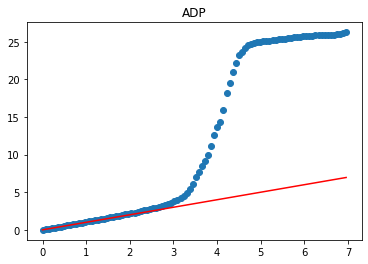

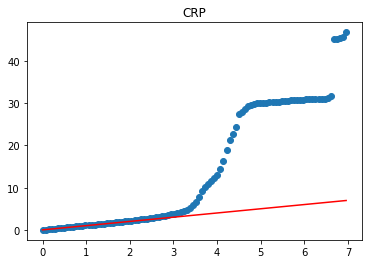

In [10]:
def QQ_plot(df):
    q_bins = np.logspace(-np.log10(df.shape[0]),0,100)
    q_values = np.log10(df["P_BOLT_LMM"].quantile(q_bins).values)
    plt.scatter(-np.log10(q_bins), -q_values)
    plt.plot([0,-np.log10(np.min(q_bins))], [0,-np.log10(np.min(q_bins))], c="red")

for ago in agonists:
    plt.figure()
    QQ_plot(bolt.loc[bolt.exp == ago])
    plt.title(ago)

## Manhattan plot

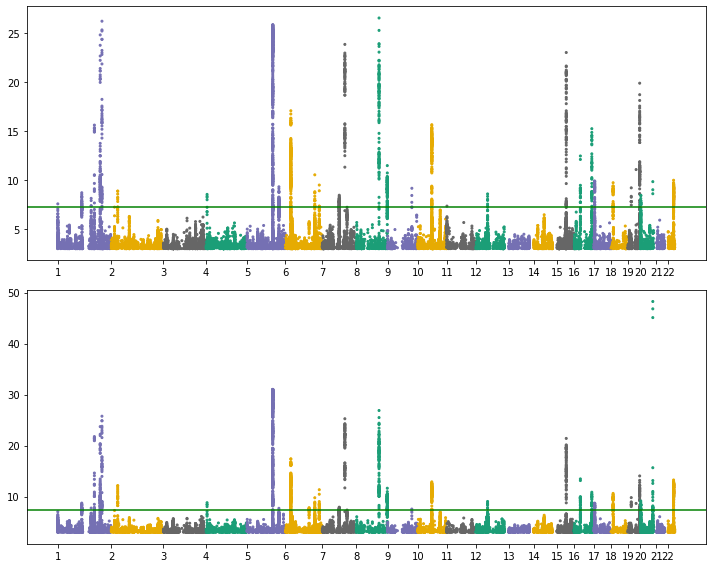

In [20]:
fig = plt.figure(figsize=(10,3*len(agonists)+2))
for i, ago in enumerate(agonists):
    ax = fig.add_subplot(len(agonists),1,i+1)
    df = bolt.loc[(bolt.exp == ago) & (bolt.P_BOLT_LMM < 1e-3)]
    ax.scatter(df.ABS_POS,-np.log10(df.P_BOLT_LMM),c=df.CHR % 4,s=4,cmap="Dark2")
    ax.set_xticks([df.loc[df.CHR == ch].ABS_POS.min() for ch in range(1,23)])
    ax.set_xticklabels(["%d" % ch for ch in range(1,23)])
    plt.axhline(-np.log10(5e-8),c="green")
plt.tight_layout()

# Association to features

In [122]:
features = pd.read_csv("%s/features.csv" % export_folder, sep="\t")
covars = pd.read_csv("%s/covariates.csv" % export_folder, sep="\t")
f_cols = features.columns[2:-4]

In [123]:
features.head()

,FID,IID,high_10_0,high_10_1,high_20_0,high_20_1,high_50_0,high_50_1,low_10_0,low_10_1,...,mode_1,S_0,S_1,iqr_0,iqr_1,corr,MPV_wb,PCT_wb,PDW_wb,PLT_wb
0,110018327792,110018327792,0.512389,-0.532091,0.530238,-0.471025,0.441687,-0.314875,0.250156,-0.720891,...,0.444352,0.967313,1.504484,0.281344,0.069848,0.418477,-0.750000,-1.000000,-0.678571,-0.458333
1,110018483652,110018483652,1.166945,-0.033822,1.062551,-0.045256,0.987633,0.036630,1.661541,0.338230,...,0.567618,0.118756,0.425957,0.015476,-0.922220,0.247815,1.000000,-0.285714,1.142857,-0.597222
2,110001259381,110001259381,0.616211,-0.347955,0.623018,-0.297589,0.512161,-0.429401,1.075472,-0.147520,...,-0.420493,0.829441,0.202695,-0.432534,-0.457062,-0.358357,0.833333,-0.714286,0.857143,-0.861111
3,110004412832,110004412832,0.594799,0.406168,0.596421,0.444563,0.536050,0.477392,0.294502,0.599917,...,0.485224,1.028649,0.231348,0.569193,-0.372125,-0.254485,0.750000,-0.571429,0.785714,-0.736111
4,110003866786,110003866786,-0.188392,1.030546,-0.096827,1.069037,0.000878,1.084369,-0.274666,0.608039,...,-0.370675,0.061850,-1.782047,-0.075203,0.647698,0.218441,-0.416667,-0.285714,-0.357143,-0.166667


## Check relation between Z, p, beta, SE

In [55]:
betas = pd.DataFrame()
SEs = pd.DataFrame()
p_vals = pd.DataFrame()

for c in f_cols:
    df = pd.read_csv("%s/bolt_res_%s" % (export_folder, c), sep="\t")
    betas[c] = df["BETA"]
    SEs[c] = df["SE"]
    p_col = "P_BOLT_LMM" if "P_BOLT_LMM" in df.columns else "P_BOLT_LMM_INF"
    p_vals[c] = df[p_col]
c = (SEs.isnull().sum(axis=1) + betas.isnull().sum(axis=1) == 0)
SEs = SEs.loc[c]
betas = betas.loc[c]
p_vals = p_vals.loc[c]

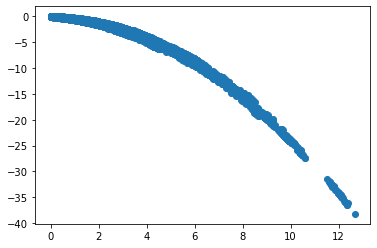

In [56]:
plt.scatter(np.abs(betas["high_10_0"] / SEs["high_10_0"]), np.log10(p_vals["high_10_0"]))

## Adjust features by covariates

In [124]:
from sklearn.linear_model import LinearRegression

In [125]:
c_cols = list(covars.columns[3:5]) + list(covars.columns[9:]) # not using cohort_covar
sys_cols = [c for c in features.columns if "_wb" in c]
m = pd.merge(features, covars[["IID","age_covar","sexPulse"]+c_cols],left_on="IID",right_on="IID",how="inner")

In [126]:
Y = m[f_cols].copy()
X = m[c_cols + sys_cols]

In [127]:
Y.head()

,high_10_0,high_10_1,high_20_0,high_20_1,high_50_0,high_50_1,low_10_0,low_10_1,low_20_0,low_20_1,...,ratio_20,mean_std_0,mean_std_1,mode_0,mode_1,S_0,S_1,iqr_0,iqr_1,corr
0,0.512389,-0.532091,0.530238,-0.471025,0.441687,-0.314875,0.250156,-0.720891,0.116447,-0.820271,...,-0.318519,0.544539,-0.592743,0.277345,0.444352,0.967313,1.504484,0.281344,0.069848,0.418477
1,1.166945,-0.033822,1.062551,-0.045256,0.987633,0.036630,1.661541,0.338230,1.652553,0.348129,...,-0.304197,1.498397,0.150270,1.646716,0.567618,0.118756,0.425957,0.015476,-0.922220,0.247815
2,0.616211,-0.347955,0.623018,-0.297589,0.512161,-0.429401,1.075472,-0.147520,1.063616,-0.009189,...,-0.215665,0.900385,-0.312391,0.334125,-0.420493,0.829441,0.202695,-0.432534,-0.457062,-0.358357
3,0.594799,0.406168,0.596421,0.444563,0.536050,0.477392,0.294502,0.599917,0.244817,0.638259,...,-0.556568,0.407553,0.539967,-0.426973,0.485224,1.028649,0.231348,0.569193,-0.372125,-0.254485
4,-0.188392,1.030546,-0.096827,1.069037,0.000878,1.084369,-0.274666,0.608039,-0.163151,0.584709,...,0.510376,-0.348314,0.812202,-1.083120,-0.370675,0.061850,-1.782047,-0.075203,0.647698,0.218441


In [128]:
X.head()

,sexPulse,sexPulse,age_covar,age_covar,PC1,PC2,PC3,PC4,PC5,MPV_wb,PCT_wb,PDW_wb,PLT_wb
0,2,2,-0.631139,-0.631139,-0.003431,-0.004429,0.005799,0.005465,-0.004632,-0.750000,-1.000000,-0.678571,-0.458333
1,2,2,0.693835,0.693835,0.006413,0.005157,0.008395,0.002881,0.008806,1.000000,-0.285714,1.142857,-0.597222
2,2,2,-0.714734,-0.714734,0.001189,-0.001928,0.007722,-0.014941,0.004064,0.833333,-0.714286,0.857143,-0.861111
3,2,2,0.535005,0.535005,-0.009439,-0.007902,0.003113,-0.002499,-0.000451,0.750000,-0.571429,0.785714,-0.736111
4,2,2,0.815047,0.815047,-0.001606,-0.000988,-0.006682,-0.002042,-0.003743,-0.416667,-0.285714,-0.357143,-0.166667


In [129]:
Y_pred = LinearRegression().fit(X,Y).predict(X)

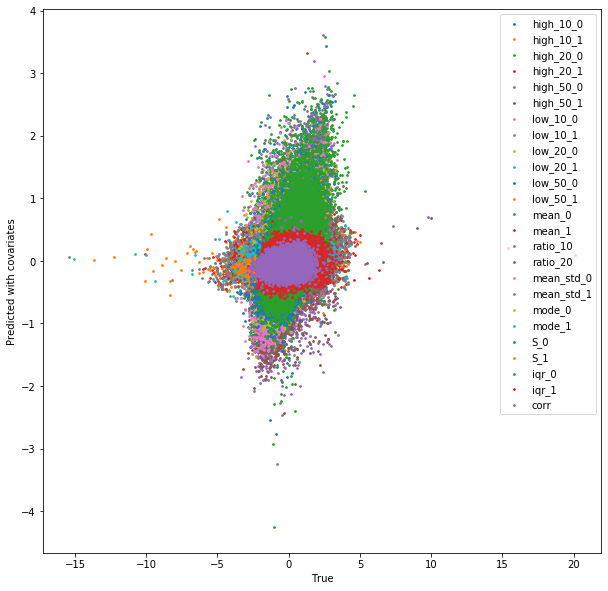

In [130]:
plt.figure(figsize=(10,10))
for c in range(Y.shape[1]):
    plt.scatter(Y.iloc[:,c],Y_pred[:,c],label=Y.columns[c],s=3)
plt.xlabel("True")
plt.ylabel("Predicted with covariates")
plt.legend()

In [131]:
adjusted_features = m.copy()
adjusted_features[Y.columns] = Y - Y_pred

In [132]:
SEs.index = bolt.loc[bolt.exp == "ADP"].SNP.tolist()
betas.index = bolt.loc[bolt.exp == "ADP"].SNP.tolist()
p_vals.index = bolt.loc[bolt.exp == "ADP"].SNP.tolist()

## Test whether association is good compared to random

- PCA of features space
- sampling of latent space
- re-projection into features space (= random features combination)
- add betas and SE
- get estimation of Z score and compare to the one found with predicted phenotype

In [133]:
adjusted_features.shape

(29498, 40)

In [134]:
pca = PCA(n_components = 10).fit(adjusted_features[f_cols].values)

In [135]:
def test_snp(SEs,betas,pca):
    n_splits = 10000
    
    beta = np.zeros(n_splits)
    try:
        for i in range(n_splits):
            indep_lambda = np.random.normal(size=(pca.n_components_))
            indep_lambda = indep_lambda * np.sqrt(pca.explained_variance_ratio_)
            
            corr_lambda = pca.inverse_transform(indep_lambda.T)
            
            beta[i] = np.sum(betas.values * corr_lambda)
    except Exception as e:
        print(e)
        pass
    return beta

In [136]:
adp_crp

,CHR_ADP,block,MBP_ADP,P_BOLT_LMM_ADP,A1FREQ,P_BOLT_LMM_CRP,CHR_CRP,MBP_CRP,CHR,MBP,Q_ADP,Q_CRP
SNP,,,,,,,,,,,,
rs73031718,1.0,0.0,171.0,1.400000e-09,0.875026,6.200000e-13,1.0,171.0,1,171,0.3354,0.2097
rs12132016,1.0,1.0,198.0,3.100000e-09,0.763101,3.700000e-08,1.0,198.0,1,198,0.0128,0.0112
rs7512948,1.0,2.0,113.0,4.600000e-08,0.469162,NaN,NaN,NaN,1,113,0.0025,0.0005
rs12068889,1.0,3.0,1.0,2.600000e-08,0.983450,NaN,NaN,NaN,1,1,0.0023,0.0014
rs72698679,1.0,4.0,156.0,1.200000e-08,0.897258,1.800000e-08,1.0,156.0,1,156,0.0000,0.0000
rs4142866,1.0,5.0,207.0,1.900000e-08,0.490062,1.500000e-08,1.0,207.0,1,207,0.5423,0.4971
rs711229,2.0,6.0,31.0,1.500000e-08,0.312709,NaN,NaN,NaN,2,31,0.3463,0.2274
rs11734099,4.0,7.0,6.0,9.900000e-09,0.825542,9.400000e-09,4.0,6.0,4,6,0.0279,0.0139
rs4240383,5.0,8.0,122.0,1.900000e-08,0.177935,6.100000e-09,5.0,122.0,5,122,0.3244,0.2607


In [105]:
best.head()

,MBP,P_BOLT_LMM,A1FREQ,Q
SNP,,,,
rs73031718,171,1.400000e-09,0.875026,1
rs12132016,198,3.100000e-09,0.763101,1
rs7512948,113,4.600000e-08,0.469162,1
rs12068889,1,2.600000e-08,0.983450,1
rs72698679,156,1.200000e-08,0.897258,1


In [142]:
colors = ["blue","grey","orange","purple","yellow"]
bests = {}
for ago in agonists:
    best = best_of(bolt.loc[bolt.exp == ago],threshold = 5e-8).set_index("SNP")
    best["Q"] = 1
    for SNP in best.index.tolist():

        #plt.figure()
        good_cols = [c for c in p_vals.columns if p_vals.loc[SNP,c] < 5e-7]
        beta_ = betas.loc[SNP].copy()
        beta_[[c for c in beta_.index if c not in good_cols]] = 0

        random_betas = test_snp(SE_, beta_,pca)
        beta_abs = np.abs(random_betas)

        #plt.hist(random_betas,
        #         label="random combination of features",
        #         color="green",alpha=.4,bins=50)

        b = np.abs(best.loc[SNP,"BETA"])
        best.loc[SNP,"Q"] = np.mean(beta_abs > b)
        #for i in range(b.shape[0]):
        #    plt.axvline(b.iloc[i,1],label=b.iloc[i,0],color = colors[i])
        #plt.legend()
        #plt.title("%s\n%d features used" % (SNP,len(good_cols)))
    bests[ago] = best

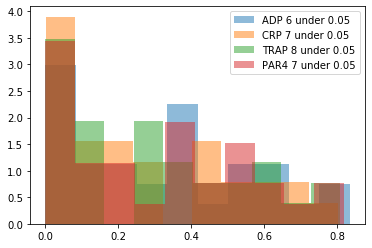

In [143]:
plt.hist(bests["ADP"].Q,alpha=.5,label="ADP %d under 0.05" % (bests["ADP"].Q < 0.05).sum(),density=True)
plt.hist(bests["CRP"].Q,alpha=.5,label="CRP %d under 0.05" % (bests["CRP"].Q < 0.05).sum(),density=True)
plt.hist(bests["TRAP"].Q,alpha=.5,label="TRAP %d under 0.05" % (bests["TRAP"].Q < 0.05).sum(),density=True)
plt.hist(bests["PAR4"].Q,alpha=.5,label="PAR4 %d under 0.05" % (bests["PAR4"].Q < 0.05).sum(),density=True)
plt.legend()


In [144]:
b = bests["PAR4"]
b.loc[b.Q < 0.05]

,CHR,block,MBP,P_BOLT_LMM,A1FREQ,BETA,Q
SNP,,,,,,,
rs12132016,1,1,198,4.700000e-09,0.763101,-0.042320,0.0398
rs12068889,1,3,1,4.400000e-08,0.983450,-0.131255,0.0196
rs13239000,7,15,116,4.000000e-08,0.751989,0.037922,0.0040
rs56077246,8,16,144,4.000000e-08,0.584882,-0.032362,0.0274
rs137950543,9,18,113,1.700000e-08,0.981691,-0.125202,0.0000
rs10506328,12,20,54,2.600000e-08,0.361099,-0.033711,0.0414
rs73076965,20,29,1,2.200000e-08,0.802577,-0.040445,0.0070


CRP : 
- 'rs72698679' : PEAR1
- 'rs9649527' : CD36
- 'rs13239000' : CAPZA2
- 'rs7010805' : PLEC
- 'rs148192036' : PPP4R1
- 'rs10498727' :  CARMIL1
- 'rs73076965' : SIRPD
- 'rs4838959' : ST7L
- 'rs12132016' : PTPRC (MIR18A1HG)
- 'rs8109288' : TPM4
- 'rs11734099' : TBC1D14
- 'rs117149770' : TXNDC8
- 'rs10506328' : NFE2

ADP : 
- PEAR1
- CD36
- TXNDC8 (proche de SVEP1)
- PLEC 
- ATAD3A
- ST7L
- CARMIL1
- SIRPD
- PTPRC (MIR18A1HG)
- TPM4
- ABLIM2
- NFE2
- PPP4R1

In [102]:
adp_crp.loc["rs530895836"]

CHR_ADP           1.900000e+01
block             2.700000e+01
MBP_ADP           5.500000e+01
P_BOLT_LMM_ADP    1.100000e-10
A1FREQ            2.164270e-01
P_BOLT_LMM_CRP    3.000000e-08
CHR_CRP           1.900000e+01
MBP_CRP           5.500000e+01
CHR               1.900000e+01
MBP               5.500000e+01
Q_ADP             3.402000e-01
Q_CRP             3.662000e-01
Name: rs530895836, dtype: float64

In [ ]:
def random_test(df, threshold = 1e-3, n_splits=1000):
    
    df["Z"] = (df["BETA"] / df["SE"]).abs()
    cond = df.P_BOLT_LMM < threshold
    snps_of_interest = df.loc[cond].SNP.tolist()
    pca = PCA(n_components = 10).fit(features[f_cols].values)
    
    Z = np.zeros((len(snps_of_interest),n_splits))
    for i in range(n_splits):
        indep_lambda = np.random.normal(size=(pca.n_components_,1))
        indep_lambda = indep_lambda * np.sqrt(pca.explained_variance_ratio_)
        corr_lambda = pca.inverse_transform(indep_lambda.T)
        beta = betas.loc[cond].values @ corr_lambda.T
        SE = np.sqrt((SEs.loc[cond].values ** 2) @ (corr_lambda ** 2).T)
        Z[:,i] = (beta / SE)[:,0]    
    
    scale = df.loc[cond,"Z"].quantile(0.1) / np.quantile(np.median(np.abs(Z),axis=1),0.1)
    #print(df.loc[cond,"Z"].quantile(0.1), 
    #      np.median(np.abs(Z),axis=1),
    #      np.quantile(np.median(np.abs(Z),axis=1),0.1), 
    #      scale)
    plt.hist(np.reshape(df.loc[cond,"Z"].abs(),(-1,)),bins=100,density=True,alpha=0.6,label="Phenotype")
    plt.hist(scale*np.reshape(np.median(np.abs(Z),axis=1),(-1,)),bins=100,density=True,alpha=0.6,label="Random phenotyopes")
    plt.yscale("log")
    
    sub_df = df.loc[cond]
    return Z, best_of(sub_df.loc[sub_df.Z > scale*np.quantile(np.abs(Z),0.99,axis=1)],threshold=threshold)

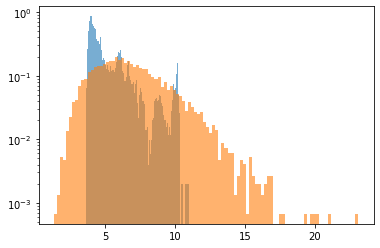

In [18]:
Z, b = random_test(adp,threshold=1e-3,n_splits=300)
b

,,SNP,P_BOLT_LMM,A1FREQ
CHR,MBP,,,
1,198,rs12023247,7.700000e-11,0.235642
5,122,rs42536,3.500000e-25,0.330233
6,25,rs214735,4.800000e-14,0.591636
7,106,rs342258,3.200000e-20,0.558919
10,65,rs7909960,3.500000e-12,0.525452
15,65,rs2630502,2.700000e-18,0.835306
16,81,rs13335344,1.300000e-14,0.856908


,,SNP,P_BOLT_LMM,A1FREQ
CHR,MBP,,,
1,198,rs12023247,8.300000e-10,0.235642
5,122,rs246282,2.500000e-32,0.330294
6,25,rs214735,1.000000e-14,0.591636
7,106,rs342294,1.000000e-21,0.545913
8,106,rs1901062,6.700000e-11,0.416055
10,65,rs7909960,2.500000e-09,0.525452
11,72,rs7929689,5.200000e-04,0.083339
15,65,rs2630502,1.100000e-17,0.835306
16,81,rs13335344,1.500000e-10,0.856908


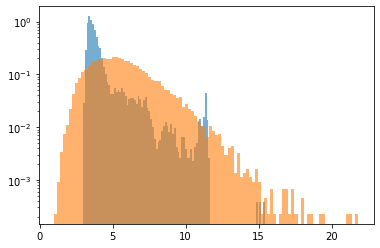

In [80]:
Z, b = random_test(crp,threshold=1e-3,n_splits=300)
b

,,SNP,P_BOLT_LMM,A1FREQ
CHR,MBP,,,
1,198,rs12023247,1.200000e-10,0.235642
5,122,rs404442,2.300000e-28,0.669154
6,25,rs214735,8.900000e-14,0.591636
7,106,rs61584365,7.800000e-19,0.562227
8,106,rs1901062,2.000000e-11,0.416055
10,65,rs7909960,2.600000e-10,0.525452
11,72,rs7929689,9.200000e-04,0.083339
15,65,rs2630502,2.200000e-18,0.835306
16,81,rs62045702,2.500000e-14,0.857186


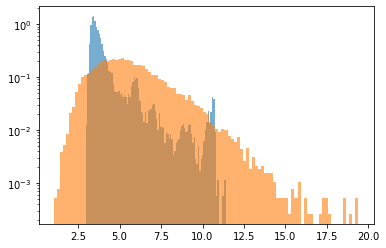

In [81]:
Z, b = random_test(par,threshold=1e-3,n_splits=300)
b

In [82]:
Z.shape

(21011, 300)

(array([62., 47., 53., 47., 34., 22., 12., 13.,  6.,  4.]),
 array([0.00937837, 0.25473223, 0.5000861 , 0.74543996, 0.99079382,
        1.23614769, 1.48150155, 1.72685542, 1.97220928, 2.21756315,
        2.46291701]),
 <a list of 10 Patch objects>)

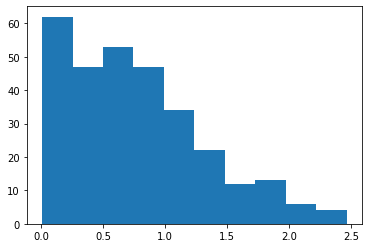

In [87]:
plt.hist(np.abs(Z)[2])

In [88]:
par.loc[par.P_BOLT_LMM < 1e-3].iloc[2]

SNP               rs543549289
CHR                         1
BP                    1435881
GENPOS                      0
ALLELE1                     G
ALLELE0                     A
A1FREQ               0.988579
F_MISS              0.0125021
BETA               -0.0385906
SE                  0.0113806
P_BOLT_LMM_INF         0.0007
P_BOLT_LMM            0.00082
MBP                         1
Z                     3.39091
Name: 2574, dtype: object

# Build random phenotypes

In [4]:
n_splits = 10000

In [26]:
# Random phenotypes
rp = pd.DataFrame(index=features.index, data=features[["FID","IID"]])

n_features = len(f_cols)
F = features[f_cols].values
pca = PCA(n_components=10).fit(features[f_cols])
for i in range(n_splits):
    indep_lambda = np.random.normal(size=(10,1))
    indep_lambda = indep_lambda.T * np.sqrt(pca.explained_variance_ratio_)
    corr_lambda = pca.inverse_transform(indep_lambda)
    f = F @ corr_lambda.T
    rp["rp_%d" % i] = f

In [27]:
rp.sample(2)

,FID,IID,rp_0,rp_1,rp_2,rp_3,rp_4,rp_5,rp_6,rp_7,...,rp_9990,rp_9991,rp_9992,rp_9993,rp_9994,rp_9995,rp_9996,rp_9997,rp_9998,rp_9999
27311,110016984456,110016984456,2.255375,0.035396,1.377958,-0.600536,-0.646635,0.973431,2.336119,-1.161307,...,-2.681597,1.551241,-1.243720,-1.089980,0.335395,1.216803,-1.773299,-2.557567,-0.585718,-0.347456
23806,110006630461,110006630461,-2.545203,-0.341297,0.455823,0.800894,-1.690402,-0.792004,-2.708115,0.093065,...,2.298460,-1.274983,0.438382,0.580248,-0.465462,-1.402749,0.008679,1.596984,1.166144,-0.353498


In [28]:
good_snps = adp.loc[adp.P_BOLT_LMM < 1e-4].SNP.unique().tolist()
print("Keeping %d good SNPS" % len(good_snps))
with open("%s/interesting_snps" % export_folder,"w") as f:
    for ID in good_snps:
        f.write("%s\n" % ID)

Keeping 7222 good SNPS


In [29]:
rp.to_csv("%s/random_phenos.csv" % export_folder, sep="\t", index=False)

## Run GWAS on these

In [30]:
tag = "random_pheno"
for k in range(1,23):
    command = "/home/hv270/Plink2/plink2 "

    command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
    command += "--glm hide-covar \
        --keep %s/king-cutoff.king.cutoff.in.id \
        --extract %s/interesting_snps \
        --pheno %s/random_phenos.csv \
        --covar %s/covariates.csv \
        --out %s/random_phenotypes_gwas/chr_%d \
        --threads %d" % (export_folder,
                            export_folder,
                            export_folder,
                            export_folder,
                            export_folder,
                            k,
                            n_splits)
    
    f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr_%d\n" % k)
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=0:20:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %d" % k)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


## Read P-values of associations

In [5]:
all_p_values = []
for ch in range(1,23):
    for pheno in range(n_splits):
        if pheno == 0:
            p_values = pd.read_csv("%s/random_phenotypes_gwas/chr_%d.rp_%d.glm.linear" % (export_folder, ch, pheno), 
                               sep="\t")
            p_values.rename(columns={"P":"P_0"},inplace=True)
        else:
            p_values["P_%d" % pheno] = pd.read_csv("%s/random_phenotypes_gwas/chr_%d.rp_%d.glm.linear" % (export_folder, ch, pheno), 
                               sep="\t")["P"]
    all_p_values.append(p_values.copy())

In [6]:
all_ps = pd.concat(all_p_values,axis=0,sort=False)
p_cols = [c for c in all_ps.columns if c[:2] == "P_"]

In [48]:
all_ps["quantiles"] = all_ps[p_cols].quantile(0.01,axis=1)

In [49]:
all_ps.loc[all_ps["quantiles"] == 0.,"quantiles"] = 1e-100

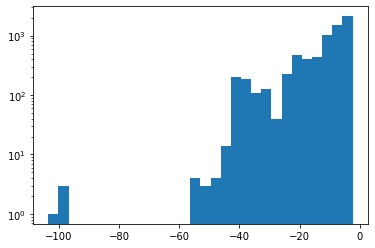

In [50]:
plt.hist(np.log10(all_ps["quantiles"]),bins=30)
plt.yscale("log")

## Run same GWAS on predicted phenotypes

In [36]:
phenos = pd.read_csv("%s/phenotypes.csv" % export_folder,sep="\t")

In [37]:
tag = "plink_pheno"
n_splits = 10
for k in range(1,23):
    command = "/home/hv270/Plink2/plink2 "

    command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % k
    command += "--glm hide-covar \
        --keep %s/king-cutoff.king.cutoff.in.id \
        --pheno %s/phenotypes.csv \
        --covar %s/covariates.csv \
        --out %s/phenotypes_plink_gwas/chr_%d \
        --threads %d" % (export_folder,
                            export_folder,
                            export_folder,
                            export_folder,
                            k,
                            n_splits)
    
    f_name = "/home/hv270/interval_slurm_calls/call_chr_%d.sh" % k
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr_%d\n" % k)
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=0:20:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,k))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %d" % k)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


In [24]:
adp_plink = pd.concat([pd.read_csv("%s/phenotypes_plink_gwas/chr_%d.%s.glm.linear" % (export_folder, ch, "ADP_FIB"), sep="\t") for ch in range(1,23)],axis=0)
crp_plink = pd.concat([pd.read_csv("%s/phenotypes_plink_gwas/chr_%d.%s.glm.linear" % (export_folder, ch, "CRP_FIB"), sep="\t") for ch in range(1,23)],axis=0)
par1_plink = pd.concat([pd.read_csv("%s/phenotypes_plink_gwas/chr_%d.%s.glm.linear" % (export_folder, ch, "PAR1_FIB"), sep="\t") for ch in range(1,23)],axis=0)

In [25]:
adp_plink.head()

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P
0,1,10177,rs367896724,AC,A,AC,ADD,15453,-0.011028,0.009193,-1.199630,0.230301
1,1,10352,rs145072688,TA,T,TA,ADD,15107,0.000682,0.009258,0.073627,0.941308
2,1,11008,rs575272151,G,C,G,ADD,24594,-0.026550,0.014406,-1.842930,0.065352
3,1,11012,rs544419019,G,C,G,ADD,24587,-0.012581,0.015028,-0.837160,0.402511
4,1,13110,rs540538026,A,G,A,ADD,25038,-0.005899,0.017933,-0.328949,0.742197


In [26]:
adp_plink["MBP"] = (adp_plink["POS"] / 1e6).astype(int)
crp_plink["MBP"] = (crp_plink["POS"] / 1e6).astype(int)
par1_plink["MBP"] = (par1_plink["POS"] / 1e6).astype(int)

In [43]:
adp_plink.loc[adp_plink.P < 1e-7].sort_values("P").groupby(["#CHROM","MBP"])[["ID","P"]].first()

ID             P
#CHROM MBP                          
1      1    rs12068889  1.078820e-08
       113  rs10776757  2.002790e-09
       156  rs12566888  7.699090e-09
       171   rs6425521  2.157560e-14
       198  rs17625587  7.846740e-24
       199   rs1434282  1.668190e-24
       207   rs2808466  5.827950e-26
2      31     rs632964  1.841010e-08
4      6    rs12640189  9.720120e-09
5      122    rs152039  3.952860e-25
       150   rs4958267  7.095590e-10
6      25   rs57318254  1.016220e-15
       137  rs12191772  7.426410e-11
       158    rs688181  2.371440e-09
7      80    rs6961069  3.299220e-08
       106    rs342293  4.050730e-23
       116  rs12532926  3.737100e-08
8      106   rs6993770  2.933860e-25
       144  rs55836855  2.820070e-09
       145  rs11329885  2.166670e-11
9      113  rs61751937  9.122670e-10
10     64   rs35562567  3.256690e-13
       65   rs10822155  4.172870e-14
12     54   rs10876550  7.895540e-09
15     65   rs59001897  6.217250e-22
16     28     rs151234  4.062850e-12
       81   rs74029252  1.192740e-15
17     4      rs238232  1.498300e-10
18     9    rs11315757  1.693150e-10
19     16    rs8104011  5.162060e-09
       38   rs35496032  5.152490e-12
       55    rs1654425  5.051470e-20
20     1    rs10485824  1.226830e-08
       57     rs415064  1.335280e-10
22     43    rs2010366  6.068090e-11

In [27]:
def filter_plink(df_plink):
    df_validate = pd.merge(df_plink.copy(),all_ps, left_on="ID",right_on="ID",how="inner")
    df_validate["quantile"] = sum([(df_validate[c] > df_validate.P)*1 for c in p_cols]) / len(p_cols)
    return df_validate
    #return df_validate.loc[(df_validate.quantile > .99) & (df_validate.P < 5e-8)].sort_values("P").groupby(["#CHROM_x","MBP"])[["ID","P","quantile"]].first()

In [55]:
adp_val = filter_plink(adp_plink)
adp_val = pd.merge(adp_val,adp[["SNP","P_BOLT_LMM"]],left_on="ID",right_on="SNP")

In [56]:
adp_val.head()

,#CHROM_x,POS_x,ID,REF_x,ALT_x,A1_x,TEST_x,OBS_CT_x,BETA_x,SE_x,...,P_9993,P_9994,P_9995,P_9996,P_9997,P_9998,P_9999,quantile,SNP,P_BOLT_LMM
0,1,1431998,rs904590,A,G,A,ADD,29172,0.120461,0.023837,...,0.007234,0.323561,0.010612,0.877408,0.001354,0.115003,0.000080,1.0,rs904590,1.300000e-06
1,1,1437605,rs145442616,A,T,A,ADD,29320,0.135980,0.024878,...,0.002807,0.438410,0.005688,0.953902,0.001265,0.125720,0.000033,1.0,rs145442616,1.300000e-07
2,1,1441065,rs35185404,A,G,A,ADD,29328,0.132389,0.024781,...,0.003201,0.497177,0.006307,0.992646,0.002013,0.115919,0.000050,1.0,rs35185404,2.700000e-07
3,1,1445274,rs191817663,C,T,C,ADD,29344,0.131934,0.024730,...,0.006650,0.379859,0.010033,0.972750,0.001429,0.074001,0.000088,1.0,rs191817663,2.700000e-07
4,1,1445849,rs116272777,T,C,T,ADD,29349,0.128092,0.024804,...,0.013909,0.346662,0.015356,0.877800,0.001163,0.045218,0.000220,1.0,rs116272777,6.200000e-07


In [64]:
adp_val.loc[adp_val["quantile"] < .5].loc[adp_val.P_BOLT_LMM < 2e-8].groupby(["#CHROM_x","MBP"])[["ID","P_BOLT_LMM","quantile"]].first()

,,ID,P_BOLT_LMM,quantile
#CHROM_x,MBP,,,
1,207,rs371127800,2.600000e-11,0.4973
6,137,rs12191772,2.800000e-11,0.4884
19,38,rs35496032,8.100000e-12,0.4133
20,57,rs34524896,2.400000e-09,0.2480


In [68]:
val_cond = (adp_val["quantile"] > .95) & (adp_val.P_BOLT_LMM < 2e-8)
adp_val.loc[val_cond].groupby(["#CHROM_x","MBP"])[["ID","P_BOLT_LMM","quantile"]].first()

ID    P_BOLT_LMM  quantile
#CHROM_x MBP                                     
1        113    rs4838959  4.300000e-09    0.9829
         156   rs72698679  1.200000e-08    0.9999
         198    rs1275163  2.900000e-09    0.9709
         199    rs6427756  4.400000e-21    1.0000
4        6     rs11731274  4.300000e-09    0.9609
5        122     rs417569  1.200000e-08    0.9717
6        25      rs301395  1.500000e-08    1.0000
7        80    rs10282644  1.600000e-08    0.9772
8        106    rs4734869  2.300000e-18    0.9597
         144    rs3923387  1.300000e-08    0.9623
         145    rs7002152  6.700000e-10    0.9532
9        113  rs137950543  1.800000e-08    0.9977
15       65    rs59001897  8.800000e-24    0.9582
16       28      rs231972  1.200000e-09    0.9855
18       9       rs428598  3.800000e-10    0.9876
19       16     rs8109288  5.400000e-09    0.9646
20       1     rs73076965  1.800000e-08    0.9981

In [72]:
validated_ADP_snps = adp_val.loc[val_cond].ID.tolist()
with open("%s/validated_snps/ADP.txt" % export_folder,"w") as f:
    for snp in validated_ADP_snps:
        f.write("%s\n" % snp)

In [55]:
filter_plink(crp_plink)

ID             P
#CHROM_x MBP                          
1        1    rs12068889  4.789930e-08
         199   rs1434282  1.465520e-23
5        122  rs10455038  1.497060e-09
6        25   rs57318254  6.297990e-16
8        145   rs1134029  2.706260e-09
16       28     rs231972  1.065270e-09
18       9    rs11315757  1.504970e-11
20       1    rs10485824  3.075070e-09

In [56]:
filter_plink(par4_plink)

ID             P
#CHROM_x MBP                           
1        1     rs12068889  1.891330e-08
         156   rs72698679  3.647430e-08
         198   rs10919615  4.048700e-22
         199    rs1434282  2.191280e-24
6        25      rs212936  1.681060e-13
7        80     rs9649532  3.822030e-08
8        106    rs7830388  6.415320e-17
         145    rs1134029  2.898910e-09
9        113  rs137950543  2.744560e-08
18       9     rs11315757  1.413300e-10
20       1     rs10485824  1.310040e-08

In [46]:
adp_validate = pd.merge(adp,all_ps, left_on="SNP",right_on="ID",how="inner")

In [52]:
adp.loc[adp.SNP == "rs72698679"]

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM,MBP,Z
371948,rs72698679,1,156867327,0,T,C,0.897372,0.017232,-0.036087,0.006866,1.500000e-07,1.500000e-07,156,5.255599


In [50]:
best_of(adp_validate.loc[(adp_validate.P_BOLT_LMM < adp_validate.quantiles)])

SNP    P_BOLT_LMM    A1FREQ
CHR MBP                                    
1   198  rs10919615  7.800000e-23  0.243452
    199   rs1434282  3.200000e-25  0.265413
5   122    rs417569  1.400000e-08  0.050314
6   25   rs57318254  2.000000e-16  0.539460
8   106  rs12680936  1.800000e-12  0.421320
    144   rs6990361  2.700000e-09  0.579646
    145  rs11136335  2.700000e-09  0.603555

In [89]:
adp_plink.head()

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,MBP
0,1,10177,rs367896724,AC,A,AC,ADD,15442,-0.014561,0.009381,-1.552290,0.120614,0
1,1,10352,rs145072688,TA,T,TA,ADD,15095,0.001773,0.009465,0.187308,0.851421,0
2,1,11008,rs575272151,G,C,G,ADD,24572,-0.024161,0.014735,-1.639720,0.101077,0
3,1,11012,rs544419019,G,C,G,ADD,24566,-0.012395,0.015357,-0.807167,0.419578,0
4,1,13110,rs540538026,A,G,A,ADD,25014,-0.006106,0.018341,-0.332901,0.739212,0


In [90]:
-0.014561 / 0.009381

-1.5521799381729025

In [93]:
from scipy.stats import norm

In [95]:
2*norm.cdf(-1.5521799381729025)

0.12061917498184252

# Read summary files of all phenotypes

In [258]:
recap_df = {}

for pheno in ["ADP_FIB","CRP_FIB","PAR1_FIB","PAR4_FIB","TRAP_FIB","FIB"]:

    bolt = pd.read_csv("%s/bolt_res_%s" % (export_folder,pheno), sep="\t")
    bolt = bolt.dropna(axis=0,how="any")
    
    plink =  pd.concat([pd.read_csv("%s/phenotypes_plink_gwas/chr_%d.%s.glm.linear" % (export_folder, ch, pheno), sep="\t") for ch in range(1,23)],axis=0)
    
    val = pd.merge(plink,all_ps, left_on="ID",right_on="ID",how="inner")
    p_cols = [c for c in val.columns if c[:2] == "P_" and len(c) <= 8]
    val["test_quantile"] = pd.DataFrame(data=[val[p] < val["P"] for p in p_cols]).mean(axis=1)
    val["MBP"] = (val["POS_x"] / 1e6).astype(int)
    
    t = pd.merge(val, bolt, left_on="ID",right_on="SNP", how="inner")
    
    best = t.loc[t.P_BOLT_LMM < 1e-8].sort_values(by="P_BOLT_LMM",ascending=True)\
        .groupby(["CHR","MBP"])\
        .agg({"CHR":"first","BP":"first","ID":"first","test_quantile":"first","SNP":"count","P_BOLT_LMM":"first"})
    
    l = []
    
    for i, row in best.iterrows():
        bp = row["BP"]
        chrom = row["CHR"]

        genes = []
        k = 1
        while len(set(genes)) == 0 and k < 3**4:

            start = int(bp - k*1e5)
            stop = int(bp + k*1e5)
            hits = mv.query('chr%d:%d-%d AND _exists_:dbnsfp.genename' % (chrom, start, stop),
                            fetch_all=True,fields="dbnsfp.genename",
                            assembly="hg19")

            for a in hits:
                if type(a["dbnsfp"]["genename"]) is str:
                    genes.append(a["dbnsfp"]["genename"])
                else:
                    genes.append(a["dbnsfp"]["genename"][0])
            k*=3
        l.append(", ".join(list(set(genes))))
    best["genes"] = l
    recap_df[pheno] = best

Fetching 9736 variant(s) . . .
No more results to return.
Fetching 40343 variant(s) . . .
No more results to return.
Fetching 3053 variant(s) . . .
No more results to return.
Fetching 0 variant(s) . . .
No more results to return.
Fetching 8025 variant(s) . . .
No more results to return.
Fetching 0 variant(s) . . .
No more results to return.
Fetching 3724 variant(s) . . .
No more results to return.
Fetching 16703 variant(s) . . .
No more results to return.
Fetching 9834 variant(s) . . .
No more results to return.
Fetching 12043 variant(s) . . .
No more results to return.
Fetching 4464 variant(s) . . .
No more results to return.
Fetching 22566 variant(s) . . .
No more results to return.
Fetching 8840 variant(s) . . .
No more results to return.
Fetching 8495 variant(s) . . .
No more results to return.
Fetching 2514 variant(s) . . .
No more results to return.
Fetching 3881 variant(s) . . .
No more results to return.
Fetching 2493 variant(s) . . .
No more results to return.
Fetching 569 var

Fetching 9834 variant(s) . . .
No more results to return.
Fetching 12043 variant(s) . . .
No more results to return.
Fetching 4464 variant(s) . . .
No more results to return.
Fetching 22566 variant(s) . . .
No more results to return.
Fetching 8840 variant(s) . . .
No more results to return.
Fetching 8495 variant(s) . . .
No more results to return.
Fetching 2514 variant(s) . . .
No more results to return.
Fetching 3881 variant(s) . . .
No more results to return.
Fetching 2493 variant(s) . . .
No more results to return.
Fetching 569 variant(s) . . .
No more results to return.
Fetching 70135 variant(s) . . .
No more results to return.
Fetching 73731 variant(s) . . .
No more results to return.
Fetching 9867 variant(s) . . .
No more results to return.
Fetching 19454 variant(s) . . .
No more results to return.
Fetching 6078 variant(s) . . .
No more results to return.
Fetching 21335 variant(s) . . .
No more results to return.
Fetching 13220 variant(s) . . .
No more results to return.
Fetching

In [263]:
for p in recap_df:
    recap_df[p].to_csv("%s/recap_%s.csv" % (export_folder,p))

In [270]:
recap_df["PAR1_FIB"]

CHR         BP          ID  test_quantile  SNP    P_BOLT_LMM  \
CHR MBP                                                                 
1   113    1  113121673  rs10776757       0.089824   12  8.600000e-10   
    171    1  171942783   rs6425521       0.229000   20  2.900000e-20   
    198    1  198974904  rs10919615       0.079488   21  2.200000e-22   
    199    1  199010721   rs1434282       0.089824   59  3.300000e-25   
    207    1  207273751   rs2808466       0.023730   43  6.900000e-26   
2   31     2   31463866    rs632964       0.143689   11  1.300000e-11   
4   6      4    6893181  rs12640189       0.298879    4  1.400000e-09   
5   122    5  122212822    rs246271       0.110205  591  1.900000e-28   
    150    5  150752643   rs4958267       0.127093    4  1.800000e-09   
6   25     6   25557149  rs57318254       0.075557  293  1.600000e-18   
    137    6  137259725  rs12191772       0.092299    4  7.300000e-11   
    158    6  158092638    rs688181       0.360606    4  2.700000e-11   
7   106    7  106372219    rs342293       0.166254   88  1.000000e-26   
8   106    8  106581528   rs6993770       0.100451  113  2.300000e-27   
    144    8  144999417  rs55836855       0.116611   19  1.300000e-10   
    145    8  145030900  rs11329885       0.094919   86  8.000000e-13   
9   113    9  113312231  rs61751937       0.159849    2  4.200000e-09   
10  64    10   64916030  rs35562567       0.097685   24  3.800000e-14   
    65    10   65071215  rs10822155       0.009317  161  1.400000e-15   
12  54    12   54712308  rs10876550       0.042073    6  5.100000e-10   
15  65    15   65160392  rs59001897       0.098413   70  6.500000e-24   
16  28    16   28505660    rs151234       0.209055   20  4.000000e-13   
    81    16   81877165  rs74029252       0.153006   29  5.300000e-14   
17  4     17    4886037    rs238232       0.154608   29  3.500000e-10   
18  9     18    9617719  rs11315757       0.133644   31  9.200000e-11   
19  16    19   16196764   rs8104011       0.135828    8  1.300000e-10   
    38    19   38817628  rs35496032       0.154899    1  9.800000e-11   
    55    19   55538980   rs1654425       0.032610   96  1.100000e-17   
20  1     20    1518100  rs10485824       0.068715   16  1.200000e-09   
    57    20   57597971    rs415064       0.213568    4  1.800000e-25   
22  43    22   43381288   rs2010366       0.080070  402  7.100000e-13   

                                                     genes  
CHR MBP                                                     
1   113                         ST7L, MOV10, CAPZA1, WNT2B  
    171                                               DNM3  
    198                                              PTPRC  
    199                                              PTPRC  
    207               C4BPB, C1orf116, C4BPA, PFKFB2, YOD1  
2   31                                   EHD3, XDH, CAPN14  
4   6                                    TBC1D14, KIAA0232  
5   122                                        SNX24, SNX2  
    150                          SLC36A2, SLC36A1, SLC36A3  
6   25                                       CARMIL1, SCGN  
    137                              IL20RA, SLC35D3, PEX7  
    158                                            ZDHHC14  
7   106                                            CCDC71L  
8   106                                              ZFPM2  
    144   SPATC1, EPPK1, PUF60, NRBP2, PLEC, GRINA, PARP10  
    145          SPATC1, EPPK1, PLEC, GRINA, OPLAH, PARP10  
9   113                                              SVEP1  
10  64                                       JMJD1C, NRBF2  
    65                                              JMJD1C  
12  54   NFE2, ITGA5, HNRNPA1, COPZ1, ZNF385A, CBX5, GPR84  
15  65   SPG21, RBPMS2, PIF1, AC069368.1, ANKDD1A, PLEKHO2  
16  28   IL27, NPIPB7, EIF3CL, APOBR, AC138894.1, NUPR1...  
    81                                               PLCG2  
17  4    C17orf107, SLC25A11, MINK1, INCA1, CAMTA2, PFN...  
18  9        

In [20]:
p_cols = [c for c in val.columns if c[:2] == "P_" and len(c) <= 8]
#val["quantile"] = pd.DataFrame(data=[val[p] < val["P"] for p in p_cols]).mean(axis=1)

In [17]:
val.head()

,#CHROM_x,POS_x,ID,REF_x,ALT_x,A1_x,TEST_x,OBS_CT_x,BETA_x,SE_x,...,P_9991,P_9992,P_9993,P_9994,P_9995,P_9996,P_9997,P_9998,P_9999,quantile
0,1,1431998,rs904590,A,G,A,ADD,29172,0.120461,0.023837,...,0.592182,0.000186,0.007234,0.323561,0.010612,0.877408,0.001354,0.115003,0.000080,0.027515
1,1,1437605,rs145442616,A,T,A,ADD,29320,0.135980,0.024878,...,0.741789,0.000047,0.002807,0.438410,0.005688,0.953902,0.001265,0.125720,0.000033,0.049934
2,1,1441065,rs35185404,A,G,A,ADD,29328,0.132389,0.024781,...,0.840059,0.000059,0.003201,0.497177,0.006307,0.992646,0.002013,0.115919,0.000050,0.068278
3,1,1445274,rs191817663,C,T,C,ADD,29344,0.131934,0.024730,...,0.661962,0.000111,0.006650,0.379859,0.010033,0.972750,0.001429,0.074001,0.000088,0.165526
4,1,1445849,rs116272777,T,C,T,ADD,29349,0.128092,0.024804,...,0.553638,0.000213,0.013909,0.346662,0.015356,0.877800,0.001163,0.045218,0.000220,0.076285


In [247]:
best = t.loc[t.P_BOLT_LMM < 5e-8].sort_values(by="P_BOLT_LMM",ascending=True)\
        .groupby(["CHR","MBP"])\
        .agg({"CHR":"first","BP":"first","ID":"first","quantile":"first","SNP":"count","P_BOLT_LMM":"first"})

In [32]:
import myvariant
mv = myvariant.MyVariantInfo()

In [148]:
to_query = best.ID.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

querying 1-35...done.
Finished.
17 input query terms found dup hits:
	[('rs10776757', 2), ('rs6425521', 2), ('rs10919615', 2), ('rs632964', 3), ('rs12640189', 2), ('rs573
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [141]:
best

ID  quantile  SNP    P_BOLT_LMM
CHR MBP                                         
1   1    rs12068889  0.192750    1  2.600000e-08
    113  rs10776757  0.086767   23  1.900000e-09
    156  rs12566888  0.126802    4  7.100000e-09
    171   rs6425521  0.199884   15  2.300000e-16
    198  rs10919615  0.079633   21  5.500000e-23
    199   rs1434282  0.087786   60  1.400000e-25
    207   rs2808466  0.032319   49  5.500000e-27
2   31     rs632964  0.166109    6  1.300000e-09
4   6    rs12640189  0.271655    4  2.800000e-09
5   122    rs152039  0.132916  590  1.300000e-26
    150  rs56859579  0.178483   90  4.700000e-10
6   25   rs57318254  0.116756  301  7.900000e-18
    137  rs12191772  0.086767   10  2.800000e-11
    158    rs688181  0.344300    4  3.100000e-10
7   80    rs6961069  0.018052   50  3.400000e-09
    106    rs342293  0.154316   88  1.300000e-24
8   106   rs6993770  0.102053  114  2.600000e-27
    144  rs55836855  0.083564   20  4.700000e-10
    145  rs11329885  0.086330   90  3.200000e-12
9   113  rs61751937  0.164362    3  6.600000e-10
10  64   rs11278263  0.220847   25  5.900000e-15
    65   rs10822155  0.048770  177  2.100000e-16
11  0    rs55966801  0.139613    1  4.400000e-08
12  54   rs10876550  0.042510    7  2.500000e-09
15  65   rs59001897  0.093318   89  8.800000e-24
16  28     rs151234  0.202213   24  3.300000e-13
    81   rs74029252  0.164798   51  5.400000e-16
17  4      rs238232  0.156063   40  1.200000e-10
18  9    rs11315757  0.122725   39  1.800000e-10
19  16    rs8104011  0.201922    8  6.000000e-10
    38   rs35496032  0.162760    1  8.100000e-12
    55    rs1654425  0.066240  105  1.200000e-20
20  1     rs6136477  0.085165   17  3.600000e-09
    57     rs415064  0.194351    3  1.400000e-10
22  43    rs2010366  0.074683  387  1.000000e-10

In [160]:
gene_names = {}
for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    gene = a[i]["snpeff"]["ann"][0]["genename"]
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

In [161]:
gene_names

{'rs12068889': ['ATAD3A'],
 'rs10776757': ['ST7L', 'ST7L'],
 'rs12566888': ['PEAR1'],
 'rs6425521': ['DNM3', 'DNM3'],
 'rs10919615': ['RP11-16L9.3', 'LINC01222'],
 'rs1434282': ['LINC01221'],
 'rs2808466': ['C4BPB'],
 'rs632964': ['EHD3', 'EHD3', 'EHD3'],
 'rs12640189': ['KIAA0232-TBC1D14', 'KIAA0232-TBC1D14'],
 'rs152039': ['SNX24'],
 'rs56859579': ['SLC36A1'],
 'rs57318254': ['CARMIL1', 'CARMIL1', 'CARMIL1', 'CARMIL1'],
 'rs12191772': ['Y_RNA'],
 'rs688181': ['ZDHHC14', 'ZDHHC14', 'ZDHHC14'],
 'rs6961069': ['GNAT3-CD36', 'GNAT3-CD36'],
 'rs342293': ['CTB-30L5.1'],
 'rs6993770': ['ZFPM2'],
 'rs55836855': ['PLEC'],
 'rs11329885': ['PLEC'],
 'rs61751937': ['SVEP1', 'SVEP1'],
 'rs11278263': ['NRBF2', 'NRBF2'],
 'rs10822155': ['JMJD1C'],
 'rs55966801': ['ODF3'],
 'rs10876550': ['NFE2-COPZ1'],
 'rs59001897': ['PLEKHO2', 'PLEKHO2'],
 'rs151234': ['APOBR', 'APOBR'],
 'rs74029252': ['PLCG2'],
 'rs238232': ['CAMTA2'],
 'rs11315757': ['PPP4R1-AS1', 'PPP4R1-AS1', 'PPP4R1-AS1', 'PPP4R1-AS1'],
 'r

In [166]:
chrom = 1
pos = 1e6
query = "chr%d:%d-%d" % (chrom, int(pos-1e3), int(pos+1e3))

In [167]:
mv.querymany([query], returnall=True, assembly="hg19")

querying 1-1...done.
Finished.
1 input query terms found no hit:
	['chr1:999000-1001000']


{'out': [{'query': 'chr1:999000-1001000', 'notfound': True}],
 'dup': [],
 'missing': ['chr1:999000-1001000']}

In [281]:
adp_plink = pd.concat([pd.read_csv("%s/phenotypes_plink_gwas/chr_%d.%s.glm.linear" % (export_folder, ch, "ADP_FIB"), sep="\t") for ch in range(1,23)],axis=0)

In [282]:
par1_plink.loc[(adp_plink.P <1e-7) & (par1_plink["#CHROM"] == 10)]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P
246878,10,64874754,rs10995445,T,A,T,ADD,28890,0.038037,0.006667,5.70523,1.173190e-08
246885,10,64876554,rs7084569,A,G,A,ADD,29037,0.037644,0.006644,5.66547,1.480100e-08
246908,10,64882300,rs10761716,G,C,G,ADD,29170,0.040847,0.006673,6.12103,9.415620e-10
246926,10,64887856,rs10822143,T,C,C,ADD,29410,-0.043953,0.006611,-6.64798,3.023490e-11
246970,10,64901792,rs150230220,AT,A,AT,ADD,27874,0.039670,0.007346,5.39995,6.720300e-08
246978,10,64904071,rs7073746,G,A,G,ADD,29341,0.044847,0.006629,6.76580,1.350690e-11
246991,10,64907581,rs11278263,T,TGCTGTAGG,T,ADD,29264,0.046643,0.006638,7.02669,2.161260e-12
247001,10,64914016,rs35751397,TA,T,TA,ADD,29305,0.045103,0.006633,6.80017,1.064980e-11
247003,10,64914372,rs13095,C,G,C,ADD,29346,0.044970,0.006624,6.78940,1.147430e-11
247005,10,64914518,rs71461799,C,CATA,C,ADD,29222,0.045974,0.006643,6.92096,4.578360e-12
